### Q11

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
default_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/ECE219/Project1-Classification.csv")
default_data.head(3)

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports


In [4]:
data_pre = default_data
# Convert categories column to numbers
data_pre.root_label = pd.Categorical(data_pre.root_label)
data_pre['label'] = data_pre.root_label.cat.codes

# Divide the data into train-test datasets using 80%-30% split.
X_pre = data_pre.full_text
y_pre = data_pre.label

X_train, X_test, y_train, y_test = train_test_split(
    X_pre, 
    y_pre, 
    test_size=0.3,
    shuffle=True, 
    random_state=42)

print(f"shape of X_train is: {X_train.shape}.")
print(f"shape of X_train is: {X_test.shape}.")

shape of X_train is: (2205,).
shape of X_train is: (945,).


In [5]:
#Remove html tag funciton
def html_remove(text):
    html = re.compile(r'<.*?>')
    return html.sub('',text)

# Remove punctuations function
def punct_remove(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table) 

#Remove emojis function
def emoji_remove(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



# Lemmatization
def lemmatize_convert(w2_text):   
    STOPWORDS = set(stopwords.words('english'))
    lemm = WordNetLemmatizer()
    tokens = word_tokenize(w2_text)
    gen_docs = [w.lower() for w in tokens] 
    tokens = [lemm.lemmatize(token) for token in gen_docs if not token in STOPWORDS]
    text = ' '.join(tokens)
    return w2_text

X_train = X_train.apply(lambda x: html_remove(x))
X_test = X_test.apply(lambda x: html_remove(x))

X_train = X_train.apply(lambda x: punct_remove(x))
X_test = X_test.apply(lambda x: punct_remove(x))

X_train = X_train.apply(lambda x: emoji_remove(x))
X_test = X_test.apply(lambda x: emoji_remove(x))

X_train = X_train.apply(lambda x: lemmatize_convert(x))
X_test = X_test.apply(lambda x: lemmatize_convert(x))

In [6]:
#Glove Dictionary loading
def dict (glove_dim):
  embeddings_dict = {}
  path = f'/content/drive/MyDrive/Colab Notebooks/Data/ECE219/glove.6B.{glove_dim}d.txt'
  with open(path, 'r') as f: # if 'r' fails with unicode,→ error, please use 'rb'
    for line in f:  
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

#Convert to vector
def vector_convert(text_df, glove_dict):
  rows = text_df.shape[0]
  dim = len(list(glove_dict.values())[0])
  vec_df = pd.DataFrame(columns=list(range(dim)), index=list(range(rows)))
  for index in range(rows):
    text = text_df.iloc[index]
    text = text.lower()
    vec = np.zeros((1, dim))
    count = 0
    for word in text:
      if word in glove_dict:
        count += 1
        vec = vec + glove_dict[word].reshape(1, dim)
    vec_df.iloc[index] = np.array((vec/count)[0])
  return vec_df

In [7]:
glove_dim_300 = 300
emb_dict_300 = dict(glove_dim_300)

Accuracy of the model in the test set is: 0.8423280423280424.
Recall of the model in the test set is: 0.8423280423280424.
Precision of the model in the test set is: 0.8423280423280424.
F1 score of the model in the test set is: 0.8423280423280424.
Confusion matrix for the test set: 
 [[303 107]
 [ 42 493]]


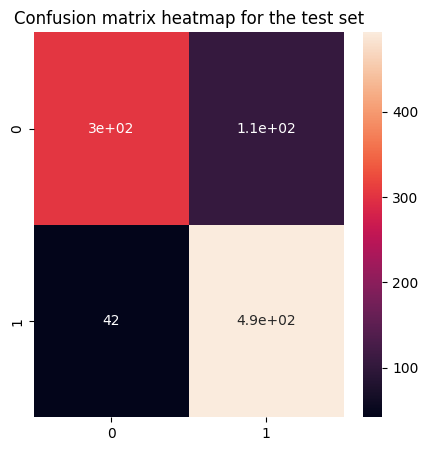

In [8]:
X_train_vc = vector_convert(X_train,emb_dict_300)
X_test_vc = vector_convert(X_test,emb_dict_300)

"""
pca = TruncatedSVD(n_components = 100)
X_train_pca = pca.fit_transform(X_train_vc)
X_test_pca = pca.transform(X_test_vc)
"""

model_lr = LogisticRegression(
    penalty='l1',
    C=100, 
    solver='liblinear', 
)
model_lr.fit(X_train_vc, y_train)

pred_test = model_lr.predict(X_test_vc)

acc_test = accuracy_score(y_test,pred_test)
print(f"Accuracy of the model in the test set is: {acc_test}.")
recall_test = recall_score(y_test,pred_test,average='micro')
print(f"Recall of the model in the test set is: {recall_test}.")
precision_test = precision_score(y_test,pred_test,average='micro')
print(f"Precision of the model in the test set is: {precision_test}.")
f1_test = f1_score(y_test,pred_test,average='micro')
print(f"F1 score of the model in the test set is: {f1_test}.")

probs_test = model_lr.predict_proba(X_test_vc)[:, 1]

confusion_matrix_test = metrics.confusion_matrix(y_test, probs_test>0.4)
print(f"Confusion matrix for the test set: \n {confusion_matrix_test}")

plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
sns.heatmap(confusion_matrix_test, annot=True)
plt.title('Confusion matrix heatmap for the test set')
plt.show()

AUC of the model in the test set is: 0.9165374971506723.


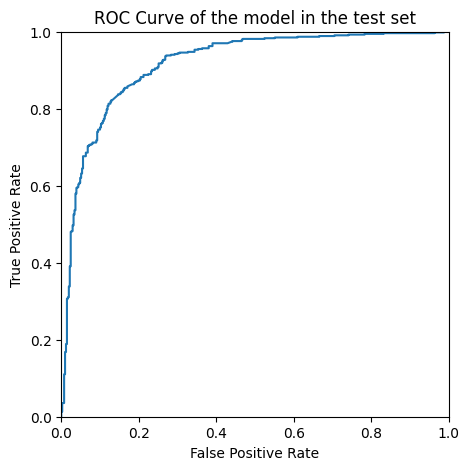

In [9]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_test)
auc_test = metrics.auc(fpr, tpr)
print(f"AUC of the model in the test set is: {auc_test}.")

plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the model in the test set')
plt.show()

### Q12

In [10]:
dims = [50,100,200,300]
acc_scores = []

glove_dim_50 = 50
emb_dict_50 = dict(glove_dim_50)
X_train_vc_50 = vector_convert(X_train,emb_dict_50)
X_test_vc_50 = vector_convert(X_test,emb_dict_50)

model_lr_50 = LogisticRegression(
    penalty='l1', 
    C=100, 
    solver='liblinear',
    max_iter=100000   
)

model_lr_50.fit(X_train_vc_50, y_train)
pred_test_50 = model_lr_50.predict(X_test_vc_50)
acc_test_50 = accuracy_score(y_test,pred_test_50)
acc_scores.append(acc_test_50)

In [11]:
glove_dim_100 = 100
emb_dict_100 = dict(glove_dim_100)
X_train_vc_100 = vector_convert(X_train,emb_dict_100)
X_test_vc_100 = vector_convert(X_test,emb_dict_100)

model_lr_100 = LogisticRegression(
    penalty='l1', 
    C=100, 
    solver='liblinear',
    max_iter=100000   
)
model_lr_100.fit(X_train_vc_100, y_train)
pred_test_100 = model_lr_100.predict(X_test_vc_100)
acc_test_100 = accuracy_score(y_test,pred_test_100)
acc_scores.append(acc_test_100)

In [12]:
glove_dim_200 = 200
emb_dict_200 = dict(glove_dim_200)
X_train_vc_200 = vector_convert(X_train,emb_dict_200)
X_test_vc_200 = vector_convert(X_test,emb_dict_200)

model_lr_200 = LogisticRegression(
    penalty='l1', 
    C=100, 
    solver='liblinear',
    max_iter=100000   
)
model_lr_200.fit(X_train_vc_200, y_train)
pred_test_200 = model_lr_200.predict(X_test_vc_200)
acc_test_200 = accuracy_score(y_test,pred_test_200)
acc_scores.append(acc_test_200)

acc_scores.append(acc_test)

The accuracy of different GLoVE dimensions for test set: 
 [0.837037037037037, 0.837037037037037, 0.8391534391534392, 0.8423280423280424].


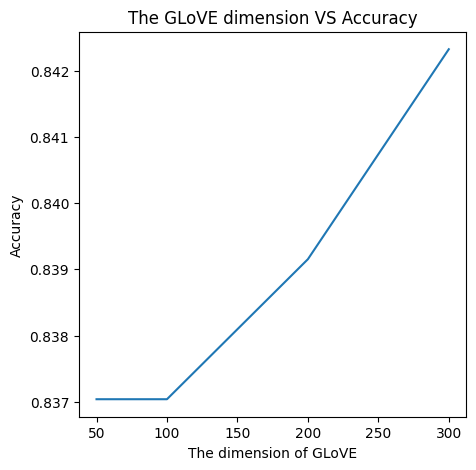

In [13]:
print(f"The accuracy of different GLoVE dimensions for test set: \n {acc_scores}.")

plt.figure()
plt.plot(dims, acc_scores)
plt.xlabel('The dimension of GLoVE')
plt.ylabel('Accuracy')
plt.title('The GLoVE dimension VS Accuracy')
plt.show()

### Q13

In [14]:
!pip install umap-learn
!pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=3073c725da77426f0d01096d2d11c6088cad421783adbc8b0d542882c8c15def
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=a1bfb6bd3e1252bd5184e96417c7b0bd7af0e79591dd9066ada1ed887727b9f5
  Stored in directory: /root/.cache/pip/wheels/12/f9/4d/ec5ad1c823c710fcc4473669fdcffc8891f4bc398c841af22e
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

In [15]:
import umap
import umap.plot

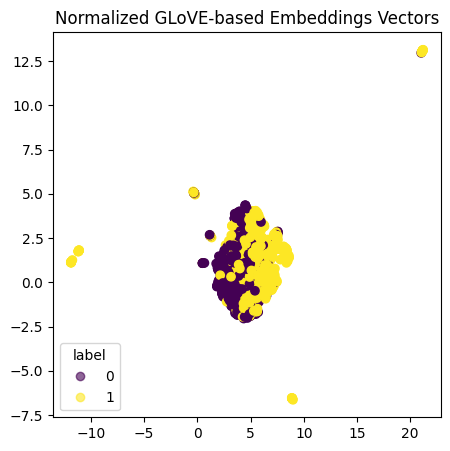

In [16]:
plot_build = umap.UMAP()
transform_after = plot_build.fit_transform(X_test_vc)

scatter_plot = plt.scatter(transform_after[:,0], transform_after[:,1], c = y_test)
plt.title("Normalized GLoVE-based Embeddings Vectors")
handles, labels = scatter_plot.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, labels, loc="lower left", title="label")
plt.show()

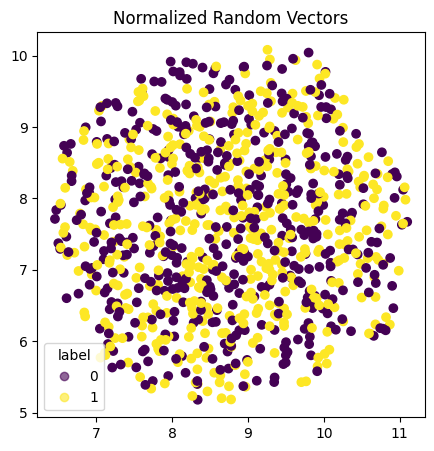

In [17]:
np.random.seed(123)
dataset = np.random.rand(len(X_test_vc),len(X_test_vc[0]))
rand_plot = plot_build.fit_transform(dataset)
rand_labels = np.random.randint(2, size = rand_plot.shape[0])

scatter_plot_2 = plt.scatter(rand_plot[:,0], rand_plot[:,1], c = rand_labels)
plt.title("Normalized Random Vectors")
handles_2, labels_2 = scatter_plot_2.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles_2, labels_2, loc="lower left", title="label")
plt.show()